@Author: Fantasy_Silence            
@Time: 2024-04-24                   
@IDE: Visual Studio Code & PyCharm  
@Python: 3.9.7                      
@Description: Using my data         

# 一、导入必要的模块

In [1]:
print("=" * 50)
print("1.导入必要的模块")
print("=" * 50)
import time
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV

from src.common.fileTool.filesio import FilesIO
from src.common.infoTool.const import CONST_TABLE
from src.common.modelTool.split import TargetVaribleSplit
from src.modules.datapreparation.dataparser import HousingDataParser
from src.modules.datapreparation.datacrawler import HousingDataSpider
from src.modules.visualization.geo_distribute import DrawGeoDistribution
from src.modules.datapreparation.pipeline58 import PipeLineFor58HousingData
from src.common.infoTool.randomIPandHeaders import RandomRequestInfoGenerator
print(
    "完成'导入必要的模块'", end="\n\n"
)

1.导入必要的模块
完成'导入必要的模块'



# 二、数据爬取与解析

In [ ]:
print("=" * 50)
print("1.数据爬取与解析")
print("=" * 50)
start_time = time.time()
for city in CONST_TABLE["CITY"].keys():
    proxies, headers = RandomRequestInfoGenerator.get()
    HousingDataSpider(city=city, headers=headers, proxies=proxies)
    HousingDataParser(city=city)
end_time = time.time()
print(
    "完成'数据爬取与解析', 用时%.3fms" % 
    ((end_time - start_time) * 1000), end="\n\n"
)

# 三、以成都的房价数据为例进行

## 1.数据可视化

In [2]:
row_data = pd.read_csv(FilesIO.getDataset("row_data/CD_housing_data.csv"))
row_data.head()

,ID,houseLoc,longitude,latitude,unitPrice,housePrice,houseArea,houseBedroom,houseLivingRoom,houseBathroom,...,houseAge,houseSubway,houseHousingPeriod,houseFloorType,houseFloorSum,busAround,schoolAround,parkAround,shopping_mallAround,subwayAround
0,1,天府新区华阳万东路80号附1号滨江和城,104.081835,30.490836,18584,170.0,91.48,3,2,2,...,6,1,满二年,低层,32,10,3,0,10,2
1,2,"高新区世纪城世纪城路996号,天府大道中段177号天鹅湖北苑",104.068682,30.559357,15935,145.0,91.00,3,2,2,...,6,1,满五年,高层,12,10,10,2,10,2
2,3,天府新区南湖南湖大道333号远大中央公园,104.046828,30.493299,18036,175.0,97.03,3,2,2,...,6,0,NaN,高层,32,10,10,0,10,1
3,4,新都大丰花都大道789号嘉美华凯(一二期),104.057887,30.762774,12030,118.0,98.09,3,2,1,...,12,1,满五年,低层,18,10,10,3,10,2
4,5,新都大丰金源街18号汇融广场B区,104.059093,30.767943,12398,113.2,91.31,3,2,1,...,8,1,满五年,中层,42,10,10,2,10,1


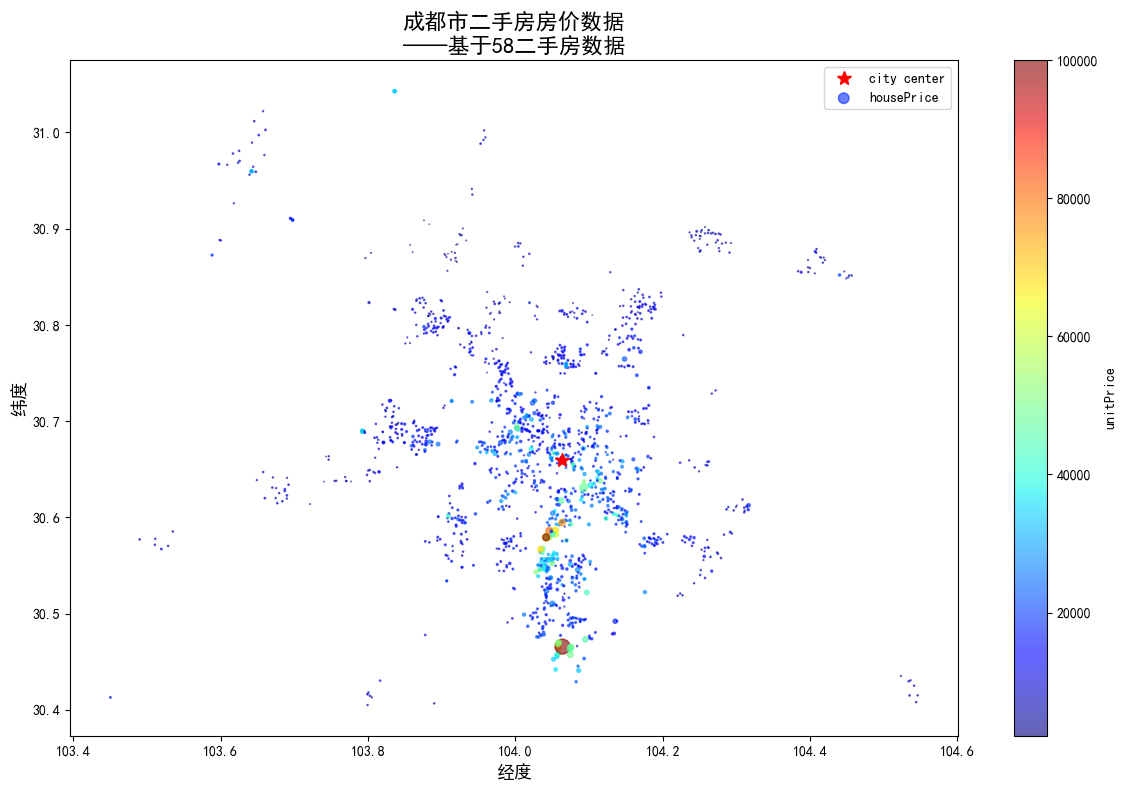

In [3]:
DrawGeoDistribution("CD").draw(is_show_alone=True, is_show=True)

## 2. 数据预处理并划分训练集

In [4]:
print("=" * 50)
print("3.2.数据预处理并划分训练集")
print("=" * 50)
start_time = time.time()
pipe_CD = Pipeline([
    ('prep', PipeLineFor58HousingData(city_name="CD")),
    ('split', TargetVaribleSplit(target="unitPrice")),
])
X_train, X_test, y_train, y_test = train_test_split(
    *pipe_CD.fit_transform(row_data), test_size=0.3, random_state=42
)
end_time = time.time()
print(
    "完成'数据预处理并划分训练集', 用时%.3fms" % 
    ((end_time - start_time) * 1000), end="\n\n"
)

3.2.数据预处理并划分训练集
完成'数据预处理并划分训练集', 用时393.139ms



## 3.寻找最佳的模型

3.3.寻找最佳的模型
Tree: -0.210561 (0.033103)
SVM: -0.141921 (0.034059)
LR: -0.154678 (0.035148)
ElasticNet: -0.307305 (0.045985)
SGD: -0.406984 (0.125621)
RF: -0.114128 (0.025470)
GB: -0.121333 (0.023584)
Ada: -0.131970 (0.028310)


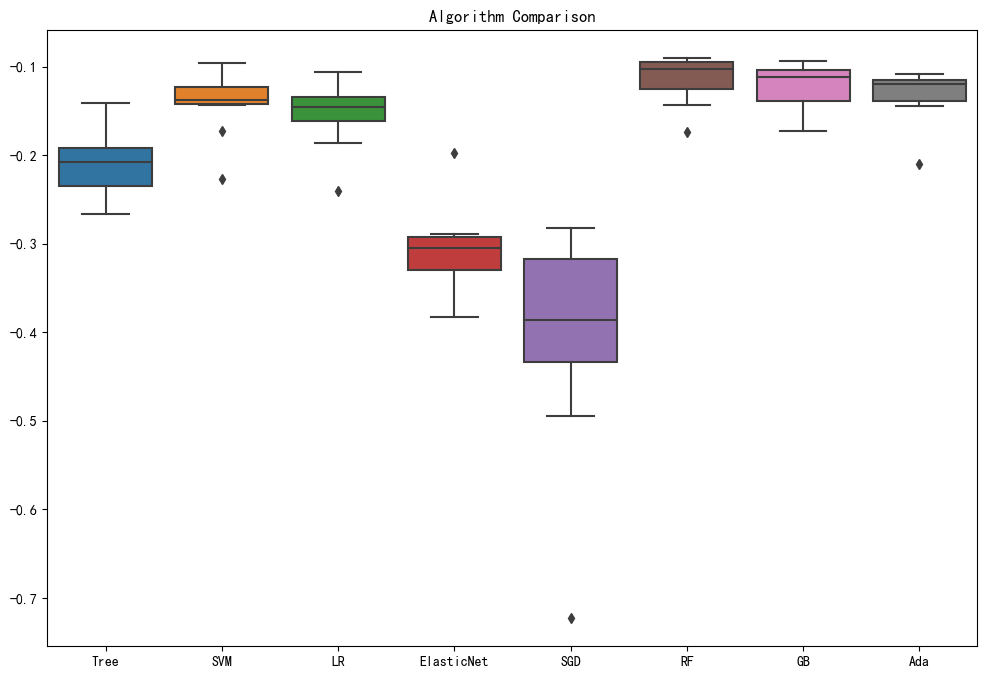

完成'寻找最佳的模型', 用时9605.550ms



In [5]:
print("=" * 50)
print("3.3.寻找最佳的模型")
print("=" * 50)
models = []
models.append(("Tree", DecisionTreeRegressor()))
models.append(("SVM", SVR()))
# 线性模型
models.append(("LR", LinearRegression()))
models.append(("ElasticNet", ElasticNet()))
models.append(("SGD", SGDRegressor()))
# Bagging
models.append(("RF", RandomForestRegressor()))
# Boost
models.append(("GB", GradientBoostingRegressor()))
models.append(("Ada", AdaBoostRegressor()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(
        model, X_train, y_train, cv=kfold, 
        scoring="neg_mean_squared_error", n_jobs=-1
    )
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
sns.boxplot(results, ax=ax)
ax.set_title('Algorithm Comparison')
ax.set_xticklabels(names)
plt.show()
end_time = time.time()
print(
    "完成'寻找最佳的模型', 用时%.3fms" % 
    ((end_time - start_time) * 1000), end="\n\n"
)

可以看到，RandomForestRegressor在十折交叉验证中表现最好，交叉验证分数的均值最高，方差(箱体的大小)相对最小，因此使用RandomForestRegressor进行进一步调参

## 4.对最佳选择进行网格搜索

In [4]:
print("=" * 50)
print("3.3.对最佳选择进行网格搜索")
print("=" * 50)
start_time = time.time()
param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_features": [0.2, 0.4, 0.6, 0.8, 1],
    "max_samples": [0.2, 0.4, 0.6, 0.8, 1],
    "criterion": ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
}
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=2
)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
end_time = time.time()
print(
    "完成'对最佳选择进行网格搜索', 用时%.3fms" % 
    ((end_time - start_time) * 1000), end="\n\n"
)

3.3.对最佳选择进行网格搜索
{'criterion': 'squared_error', 'max_features': 0.4, 'max_samples': 0.8, 'n_estimators': 400}
完成'对最佳选择进行网格搜索', 用时2383056.714ms



## 5.使用最佳模型，进行评估

In [6]:
best_regressor = RandomForestRegressor(
    n_estimators=400, max_features=0.4, max_samples=0.8, criterion="squared_error"
)
best_regressor.fit(X_train, y_train)
y_pred = best_regressor.predict(X_test)

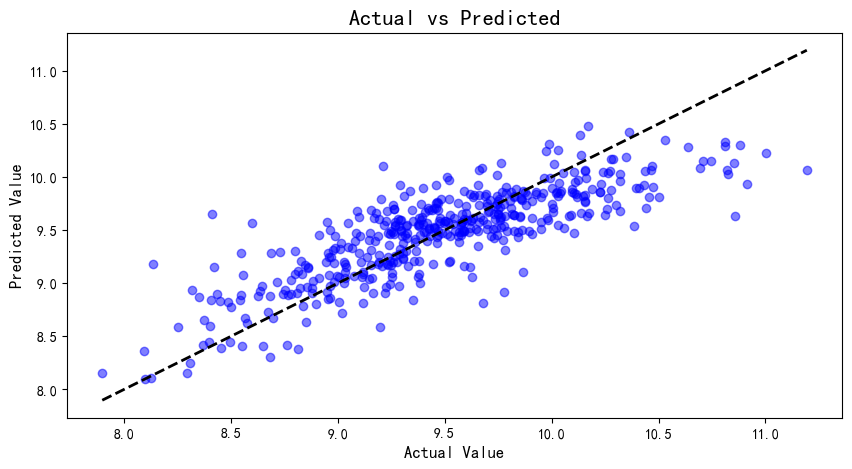

In [7]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.scatter(y_test, y_pred, c="b", alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
ax.set_title("Actual vs Predicted", fontsize=16)
ax.set_ylabel("Predicted Value", fontsize=12)
ax.set_xlabel("Actual Value", fontsize=12)
plt.show()

可以看到在训练集上的表现还是不错的，预测出的绝大多数点都集中在$y=x$附近，说明预测值与真实值的差别不大。那么换一座城市如何呢

In [8]:
# 选用北京市的房价数据进行预测
BJ_data = pd.read_csv(FilesIO.getDataset("row_data/BJ_housing_data.csv"))
BJ_data.head()

,ID,houseLoc,longitude,latitude,unitPrice,housePrice,houseArea,houseBedroom,houseLivingRoom,houseBathroom,...,houseAge,houseSubway,houseHousingPeriod,houseFloorType,houseFloorSum,subwayAround,parkAround,schoolAround,busAround,shopping_mallAround
0,1,朝阳望京望京街望京西园三区,116.468147,39.998618,63219,550.0,87.00,1,1,1,...,21.0,1,NaN,高层,18.0,2,4,10,10,10
1,2,朝阳双井广渠路66号百环家园,116.458682,39.889438,58223,558.0,95.84,2,2,1,...,19.0,1,满五年,低层,28.0,2,4,10,10,10
2,3,朝阳小红门朝阳区东南三环小红门路（和谐苑南侧）朝阳·中建星光里,116.452869,39.837565,80000,560.0,70.00,2,2,1,...,NaN,0,NaN,NaN,NaN,1,1,4,10,10
3,4,朝阳东坝平房路汇景苑三区,116.531607,39.952845,49813,399.0,80.10,2,1,1,...,9.0,0,满五年,高层,29.0,1,2,6,10,10
4,5,海淀西北旺黑龙潭路保利西山林语,116.211213,40.034080,62507,563.0,90.07,2,1,2,...,14.0,0,NaN,高层,9.0,0,0,0,0,1


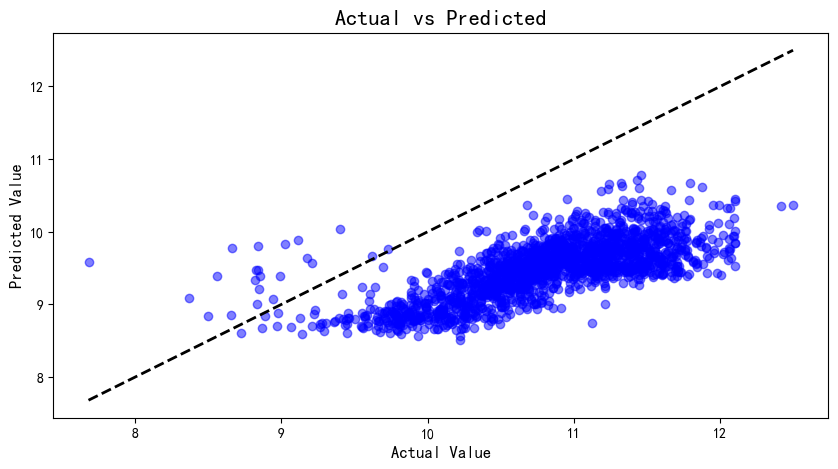

In [9]:
pipe_BJ = Pipeline([
    ('prep', PipeLineFor58HousingData(city_name="BJ")),
    ('split', TargetVaribleSplit(target="unitPrice")),
])
X_BJ, y_BJ = pipe_BJ.fit_transform(BJ_data)
y_pred = best_regressor.predict(X_BJ)
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.scatter(y_BJ, y_pred, c="b", alpha=0.5)
ax.plot([y_BJ.min(), y_BJ.max()], [y_BJ.min(), y_BJ.max()], "k--", lw=2)
ax.set_title("Actual vs Predicted", fontsize=16)
ax.set_ylabel("Predicted Value", fontsize=12)
ax.set_xlabel("Actual Value", fontsize=12)
plt.show()

可以看到预测值明显偏小，这说明模型的泛化能力并不出众

# 四、提升模型的泛化能力

## 1.重新生成训练与测试数据

在接下来的训练中，我从12座城市的数据集中，分别随机选择900条数据重新组成训练集进行训练，试图提升模型在其他城市的表现，及模型的泛化能力

In [10]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()
for city in CONST_TABLE["CITY"].keys():

    # ------ 读取数据 ------ #
    df = pd.read_csv(FilesIO.getDataset(f"row_data/{city}_housing_data.csv"))

    # ------ 处理数据 ------ #
    pipe_i = Pipeline([
        ('prep', PipeLineFor58HousingData(city_name=city)),
    ])
    df_processed = pipe_i.fit_transform(df)

    # ------ 随机选择900条组成新的训练集，剩下的为测试集 ------ #
    df_train = df_processed.sample(n=900, replace=False)
    df_test = df_processed.drop(df_train.index)
    train_data = pd.concat([train_data, df_train])
    test_data = pd.concat([test_data, df_test])

# ------ 分离特征与目标变量 ------ #
pipe_all = Pipeline([
    ('split', TargetVaribleSplit(target="unitPrice")),
])
X_train_balanced, y_train_balanced = pipe_all.fit_transform(train_data)
X_test_balanced, y_test_balanced = pipe_all.fit_transform(test_data)
X_train_balanced.fillna(0, inplace=True)
y_train_balanced.fillna(0, inplace=True)

## 2.寻找最佳的模型

Tree: -0.588284 (0.023710)
SVM: -0.432927 (0.016671)
LR: -0.463022 (0.015627)
ElasticNet: -0.638114 (0.023986)
SGD: -0.506490 (0.046730)
RF: -0.272310 (0.015607)
GB: -0.334284 (0.014332)
Ada: -0.485344 (0.017485)


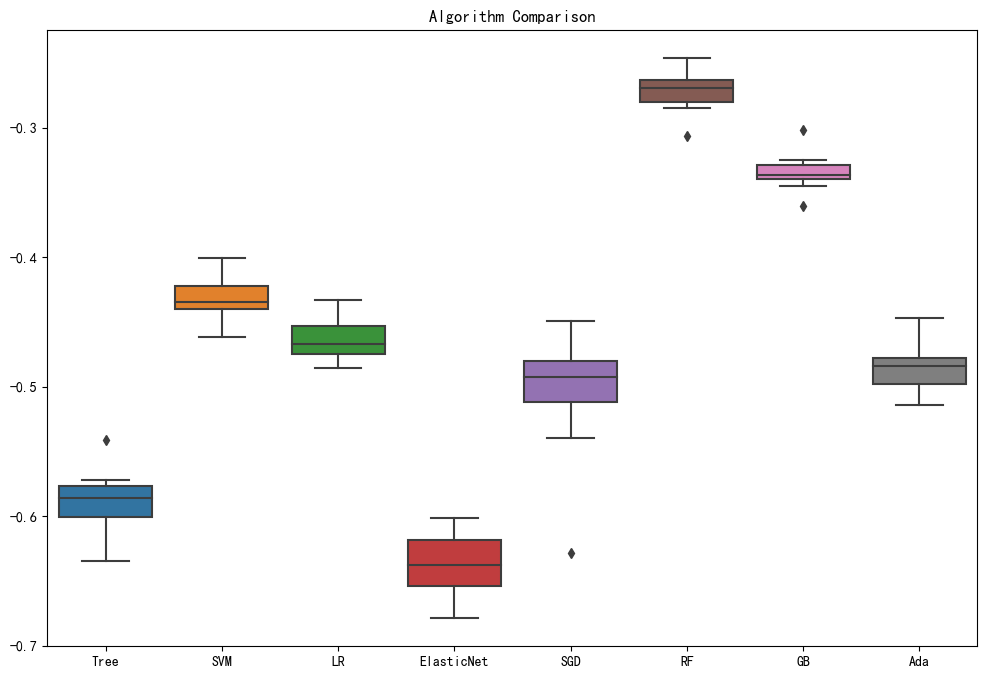

In [11]:
models = []
models.append(("Tree", DecisionTreeRegressor()))
models.append(("SVM", SVR()))
# 线性模型
models.append(("LR", LinearRegression()))
models.append(("ElasticNet", ElasticNet()))
models.append(("SGD", SGDRegressor()))
# Bagging
models.append(("RF", RandomForestRegressor()))
# Boost
models.append(("GB", GradientBoostingRegressor()))
models.append(("Ada", AdaBoostRegressor()))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(
        model, X_train_balanced, y_train_balanced, 
        cv=kfold, scoring="neg_mean_squared_error", n_jobs=-1
    )
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=100)
sns.boxplot(results, ax=ax)
ax.set_title('Algorithm Comparison')
ax.set_xticklabels(names)
plt.show()

可以看到，RandomForestRegressor在十折交叉验证中表现最好，交叉验证分数的均值最高，方差(箱体的大小)相对最小，因此使用RandomForestRegressor进行进一步调参

## 3.对最佳选择进行网格搜索

In [ ]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_features": [0.2, 0.4, 0.6],
    "max_samples": [0.2, 0.4, 0.6], 
}
kfold = KFold(n_splits=5, random_state=42, shuffle=True)
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=2
)
grid_search.fit(X_train_balanced, y_train_balanced)
print(grid_search.best_params_)

## 4.使用最佳模型，进行评估

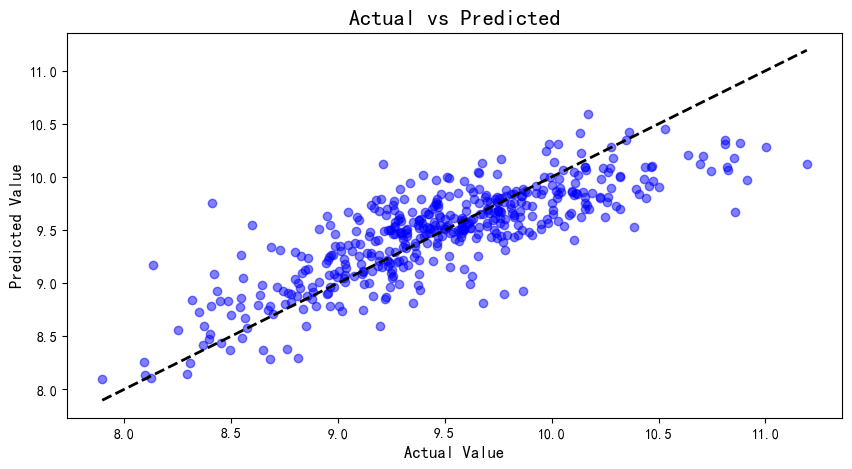

In [19]:
balanced_regressor = RandomForestRegressor(
    n_estimators=200, max_features=0.8, max_samples=0.6, criterion="squared_error"
)
balanced_regressor.fit(X_train, y_train)
y_pred = balanced_regressor.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
ax.scatter(y_test, y_pred, c="b", alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
ax.set_title("Actual vs Predicted", fontsize=16)
ax.set_ylabel("Predicted Value", fontsize=12)
ax.set_xlabel("Actual Value", fontsize=12)
plt.show()